In [1]:
#%%导入包

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import shap
import sklearn
#（边缘包）
import warnings
import streamlit as st
import pickle
import json

####（边缘函数）
from numpy import argmax
from functools import reduce
from io import StringIO
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler

###
from sklearn import svm, datasets,tree,linear_model,metrics
from sklearn.preprocessing import StandardScaler,label_binarize,OrdinalEncoder
from sklearn.ensemble import VotingClassifier,ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay,roc_auc_score,accuracy_score,roc_auc_score, roc_curve, auc,f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score,train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification,fetch_openml

###
import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

%matplotlib inline
sns.set(style="darkgrid") #设置seaborn为暗黑风格

In [2]:
random_state_new = 50
jc = 10

In [15]:
import pandas as pd  
  
df = pd.read_csv('/home/gg/jupyter_notebook_wd/Radiomice/Untitled Folder/三合一.csv')  


#df1 = pd.read_csv('(PRJNA375935)~97+114.txt', sep='\t')
#df2 = pd.read_csv('(PRJEB28545)~113+37.txt', sep='\t')

In [16]:
# # 特征提取与转换
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=random_state_new)

In [17]:
df.columns

Index(['ID', 'Pathological_fracture', 'Gender', 'Primary_site', 'Laterality',
       'Postoperative_incision_status', 'Duration_of_symptoms_to_visit', 'Age',
       'Tumor_size', 'ALP', 'Ca', 'Leukocyte', 'Monocyte', 'Monocyte_ratio',
       'Lymphocyte', 'Neutrophil', 'NLR', 'MLR', 'survival',
       'wavelet-LLH_glszm_GrayLevelNonUniformity',
       'wavelet-LHL_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-HHH_glcm_ClusterShade',
       'wavelet-HHH_glszm_GrayLevelNonUniformityNormalized',
       'wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-HHH_glszm_ZoneVariance', 'Feature_508', 'Feature_738',
       'Feature_879'],
      dtype='object')

# 划分数据集

In [18]:
#特征标注
features = ["Age","ALP","Monocyte","Neutrophil","MLR" ]+df.iloc[:, 25:28].columns.tolist()+df.iloc[:, 19:25].columns.tolist()
target= 'survival'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state_new)

#处理不平衡数据（重采样）
oversample = SMOTE(random_state=random_state_new)
# oversample = ADASYN()
X_train_rs, y_train_rs = oversample.fit_resample(X_train, y_train)
X_test_rs, y_test_rs = oversample.fit_resample(X_test, y_test)
# 查看原始数据集的类别分布
print('Original dataset shape:', Counter(y_train))
# 查看生成的合成样本后的类别分布
print('Resampled dataset shape:', Counter(y_train_rs))

# X = df1.iloc[:, 2:]
# y = df1.iloc[:, 1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state_new)

Original dataset shape: Counter({0: 47, 1: 33})
Resampled dataset shape: Counter({0: 47, 1: 47})


In [19]:
X_train = X_train_rs
y_train  = y_train_rs

# X_test = X_test_rs
# y_test  = y_test_rs

# 构建模型

In [20]:
#LR
logis_model = LogisticRegression(random_state=random_state_new,
                                 solver='lbfgs', multi_class='multinomial')
lr_model = logis_model.fit(X_train, y_train)
lr_model_y_prob = lr_model.predict_proba(X_test)

#MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=1,
                    power_t=0.5,
                    max_iter=200,
                    shuffle=True, random_state=random_state_new)
mlp_model = mlp_model.fit(X_train, y_train)
mlp_model_y_prob = mlp_model.predict_proba(X_test)

#NBC
NBC_model = GaussianNB(var_smoothing=1e-1)
#from sklearn.naive_bayes import BernoulliNB
#model = BernoulliNB()
NBC_model = NBC_model.fit(X_train, y_train)
NBC_model_y_prob = NBC_model.predict_proba(X_test)

#SVC
SVC_model = SVC(kernel='rbf',C=1.0,random_state=random_state_new,probability=True)
SVC_model = SVC_model.fit(X_train, y_train)
SVC_model_y_prob = SVC_model.predict_proba(X_test)

#XGB
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=2, learning_rate=1, random_state=random_state_new)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_model_y_prob = xgb_model.predict_proba(X_test)

#BAG
Bag = BaggingClassifier(KNeighborsClassifier(),
                        max_samples=0.5, max_features=0.5, random_state=random_state_new)
Bag_model = Bag.fit(X_train, y_train)
Bag_model_y_prob = Bag_model.predict_proba(X_test)

#AB
AB = AdaBoostClassifier(n_estimators=10, random_state=random_state_new)
AB_model = AB.fit(X_train, y_train)
AB_model_y_prob = AB_model.predict_proba(X_test)

#GBM
gbm = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=random_state_new)
gbm_model = gbm.fit(X_train, y_train)
gbm_model_y_prob = gbm_model.predict_proba(X_test)

#RF
RF_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=random_state_new)
RF_model = RF_model.fit(X_train, y_train)
RF_model_y_prob = RF_model.predict_proba(X_test)




/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# 最佳模型——训练集和测试集的ROC曲线

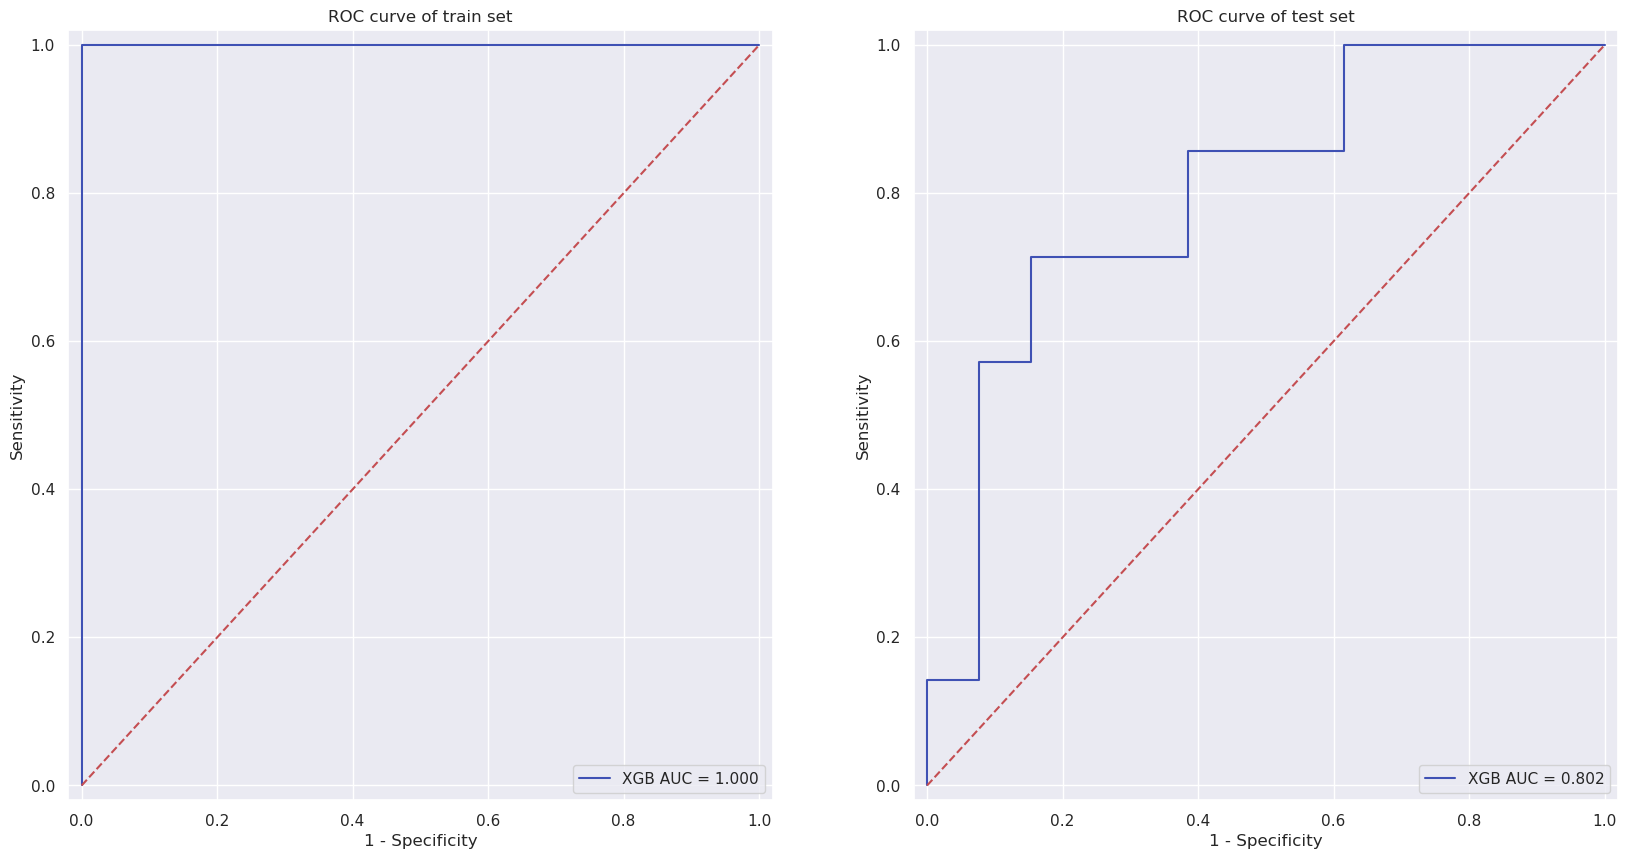

In [22]:
plt.style.use('tableau-colorblind10')
def plot_roc(k, y_pred_undersample_score, labels_test, classifiers, color, title):
    fpr, tpr, thresholds = metrics.roc_curve(labels_test.values.ravel(), y_pred_undersample_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='%s AUC = %0.3f' % (classifiers, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.title(title)

# Set custom figure size for the entire plot
plt.figure(figsize=(20, 10))  # Example of custom size
fontsize = 14 #确保字体大小一致

plt.subplot(1,2,1)
plot_roc(1,xgb_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'XGB','#3f51b4','ROC curve of train set')

plt.subplot(1,2,2)
plot_roc(1,xgb_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'XGB','#3f51b4','ROC curve of test set')

#plt.savefig("特征级—训练集-测试集ROC曲线.pdf",format="pdf")
plt.show()




In [21]:
# 获取训练集的预测概率和真实值
y_score_feature_fusion_train = xgb_model.predict_proba(X_train)[:,1]
y_true_feature_fusion_train = pd.DataFrame(y_train)

# 获取测试集的预测概率和真实值
y_score_feature_fusion_test = xgb_model.predict_proba(X_test)[:,1]
y_true_feature_fusion_test = pd.DataFrame(y_test)


## 一、堆叠模型

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
random_state_new = 50
jc = 10

In [24]:
import pandas as pd  
  
df = pd.read_csv('/home/gg/jupyter_notebook_wd/Radiomice/Untitled Folder/三合一.csv')  


#df1 = pd.read_csv('(PRJNA375935)~97+114.txt', sep='\t')
#df2 = pd.read_csv('(PRJEB28545)~113+37.txt', sep='\t')

In [25]:
# 定义目标列
target = 'survival'

# 传统影像指标
X_trad = df.iloc[:, 19:25]
y = df[target]
X_train_trad, X_test_trad, y_train, y_test = train_test_split(X_trad, y, test_size=0.2, random_state=42)

model_trad = LogisticRegression(random_state=50)
# model_trad =MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
#                     alpha=0.0001,
#                     batch_size='auto',
#                     learning_rate='constant',
#                     learning_rate_init=1,
#                     power_t=0.5,
#                     max_iter=200,
#                     shuffle=True, random_state=random_state_new)
model_trad.fit(X_train_trad, y_train)

# 深度学习影像指标
X_deep = df.iloc[:, 25:28]
X_train_deep, X_test_deep, y_train, y_test = train_test_split(X_deep, y, test_size=0.2, random_state=42)

model_deep = LogisticRegression(random_state=50)
# model_deep =GaussianNB(var_smoothing=1e-1)
model_deep.fit(X_train_deep, y_train)

# 临床指标
features_clinical = ["Age", "ALP", "Monocyte", "Neutrophil", "MLR"] 
X_clinical = df[features_clinical]
X_train_clinical, X_test_clinical, y_train, y_test = train_test_split(X_clinical, y, test_size=0.2, random_state=42)

model_clinical = LogisticRegression(random_state=50)
# model_clinical =BaggingClassifier(KNeighborsClassifier(),
#                         max_samples=0.5, max_features=0.5, random_state=random_state_new)
model_clinical.fit(X_train_clinical, y_train)


/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=50)

In [26]:
# 定义堆叠模型
estimators = [
    ('trad', model_trad),
    ('deep', model_deep),
    ('clinical', model_clinical)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42)
)

# 数据预处理，合并不同特征集作为输入
X_combined_train = pd.concat([X_train_trad, X_train_deep, X_train_clinical], axis=1)
X_combined_test = pd.concat([X_test_trad, X_test_deep, X_test_clinical], axis=1)

# 训练堆叠模型
stacking_model.fit(X_combined_train, y_train)

# 获取训练集和测试集的预测概率
y_train_pred_proba = stacking_model.predict_proba(X_combined_train)[:, 1]
y_test_pred_proba = stacking_model.predict_proba(X_combined_test)[:, 1]

# 获取训练集和测试集的类别预测
y_train_pred = stacking_model.predict(X_combined_train)
y_test_pred = stacking_model.predict(X_combined_test)

### 计算模型在测试集中的各参数结果 ####
# 计算 F1 值
F1 = f1_score(y_test, y_test_pred, average='weighted')  # 可根据数据调整为 'weighted'

# 计算 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
AUC = auc(fpr, tpr)

# 计算准确率
accuracy = accuracy_score(y_test, y_test_pred)

# 计算敏感性和特异性
TN, FP, FN, TP = confusion_matrix(y_test, y_test_pred).ravel()
sensitivity = round(TP / (TP + FN), 3)
specificity = round(TN / (TN + FP), 3)

# 输出结果
print(f'Stacking Model F1 Score: {F1:.4f}')
print(f'Stacking Model AUC: {AUC:.4f}')
print(f'Stacking Model Accuracy: {accuracy:.4f}')
print(f'Stacking Model Sensitivity: {sensitivity:.4f}')
print(f'Stacking Model Specificity: {specificity:.4f}')

# 将结果存入字典或列表中（如与其他模型的结果做对比）
stacking_model_metrics = {
    'F1': F1,
    'AUC': AUC,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}



/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Stacking Model F1 Score: 0.7288
Stacking Model AUC: 0.7802
Stacking Model Accuracy: 0.7500
Stacking Model Sensitivity: 0.4290
Stacking Model Specificity: 0.9230


/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# 获取训练集的预测概率和真实值
y_score_stacking_train = y_train_pred_proba
y_true_stacking_train = y_train

# 获取测试集的预测概率和真实值
y_score_stacking_test = y_test_pred_proba
y_true_stacking_test = y_test

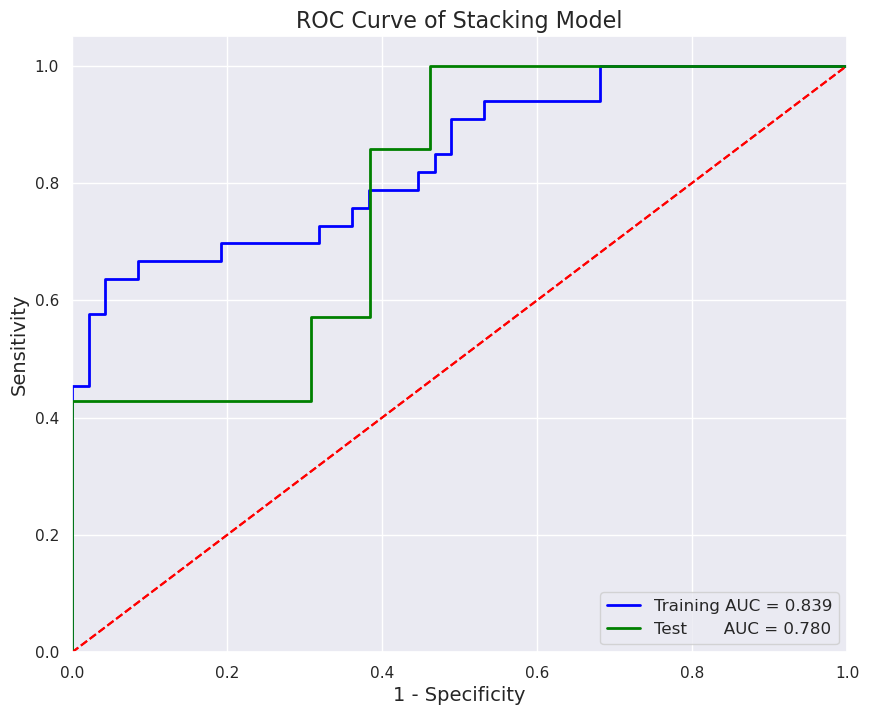

In [28]:
# 定义绘制ROC曲线的函数
def plot_roc_curve(y_true, y_score, title, color, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, 
             label='%s AUC = %0.3f' % (classifier_name, roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    
# 开始绘制
sns.set()
# sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))

# 绘制训练集ROC曲线
plot_roc_curve(y_train, y_train_pred_proba, 
               title='ROC Curve of Stacking Model', 
               color='blue', classifier_name='Training')

# 绘制测试集ROC曲线
plot_roc_curve(y_test, y_test_pred_proba, 
               title='ROC Curve of Stacking Model', 
               color='green', classifier_name='Test      ')

# 显示图像
plt.savefig('ROC Curve of Stacking Model.pdf', format='pdf')
plt.show()

## 二、投票加权模型

In [76]:
import pandas as pd
df = pd.read_csv('/home/gg/jupyter_notebook_wd/Radiomice/Untitled Folder/三合一.csv')  

### 1.网格搜索在验证集中寻找最佳权重

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix

# 定义目标列
target = 'survival'

# 传统影像指标
X_trad = df.iloc[:, 19:25]
y = df[target]
X_train_trad, X_test_trad, y_train, y_test = train_test_split(X_trad, y, test_size=0.2, random_state=42)

model_trad = LogisticRegression(random_state=50)
# model_trad =MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
#                     alpha=0.0001,
#                     batch_size='auto',
#                     learning_rate='constant',
#                     learning_rate_init=1,
#                     power_t=0.5,
#                     max_iter=200,
#                     shuffle=True, random_state=random_state_new)
model_trad.fit(X_train_trad, y_train)

# 深度学习影像指标
X_deep = df.iloc[:, 25:28]
X_train_deep, X_test_deep, y_train, y_test = train_test_split(X_deep, y, test_size=0.2, random_state=42)

model_deep = LogisticRegression(random_state=50)
# model_deep =GaussianNB(var_smoothing=1e-1)
model_deep.fit(X_train_deep, y_train)

# 临床指标
features_clinical = ["Age", "ALP", "Monocyte", "Neutrophil", "MLR"] 
X_clinical = df[features_clinical]
X_train_clinical, X_test_clinical, y_train, y_test = train_test_split(X_clinical, y, test_size=0.2, random_state=42)

model_clinical = LogisticRegression(random_state=50)
# model_clinical =BaggingClassifier(KNeighborsClassifier(),
#                         max_samples=0.5, max_features=0.5, random_state=random_state_new)
model_clinical.fit(X_train_clinical, y_train)


/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=50)

In [78]:
# 划分训练集和验证集
X_train_trad_sub, X_val_trad, y_train_sub, y_val = train_test_split(X_train_trad, y_train, test_size=0.2, random_state=42)
X_train_deep_sub, X_val_deep, _, _ = train_test_split(X_train_deep, y_train, test_size=0.2, random_state=42)
X_train_clinical_sub, X_val_clinical, _, _ = train_test_split(X_train_clinical, y_train, test_size=0.2, random_state=42)

# 获取每个模型在验证集上的预测概率
proba_trad_val = model_trad.predict_proba(X_val_trad)
proba_deep_val = model_deep.predict_proba(X_val_deep)
proba_clinical_val = model_clinical.predict_proba(X_val_clinical)

# 定义搜索空间
weight_range = np.arange(0.0, 1.1, 0.1)

# 保存AUC得分
auc_scores = []

# 网格搜索
for w_trad in weight_range:
    for w_deep in weight_range:
        w_clinical = 1.0 - w_trad - w_deep  # 确保总权重为1
        if w_clinical < 0 or w_clinical > 1:  # 保证权重有效性
            continue
        
        # 计算验证集的加权平均概率
        weighted_proba_val = (w_trad * proba_trad_val[:, 1] + 
                              w_deep * proba_deep_val[:, 1] + 
                              w_clinical * proba_clinical_val[:, 1])
        
        # 计算验证集AUC
        auc_val = roc_auc_score(y_val, weighted_proba_val)
        auc_scores.append((w_trad, w_deep, w_clinical, auc_val))

# 将结果转换为数组
auc_scores = np.array(auc_scores)

# 找到最佳权重组合
best_idx = np.argmax(auc_scores[:, 3])
best_weights = auc_scores[best_idx, :3]
best_auc = auc_scores[best_idx, 3]

print(f'最佳权重组合: 传统影像: {best_weights[0]:.2f}, 深度影像: {best_weights[1]:.2f}, 临床特征: {best_weights[2]:.2f}')
print(f'最佳AUC (验证集): {best_auc:.4f}')



最佳权重组合: 传统影像: 0.60, 深度影像: 0.30, 临床特征: 0.10
最佳AUC (验证集): 0.8000


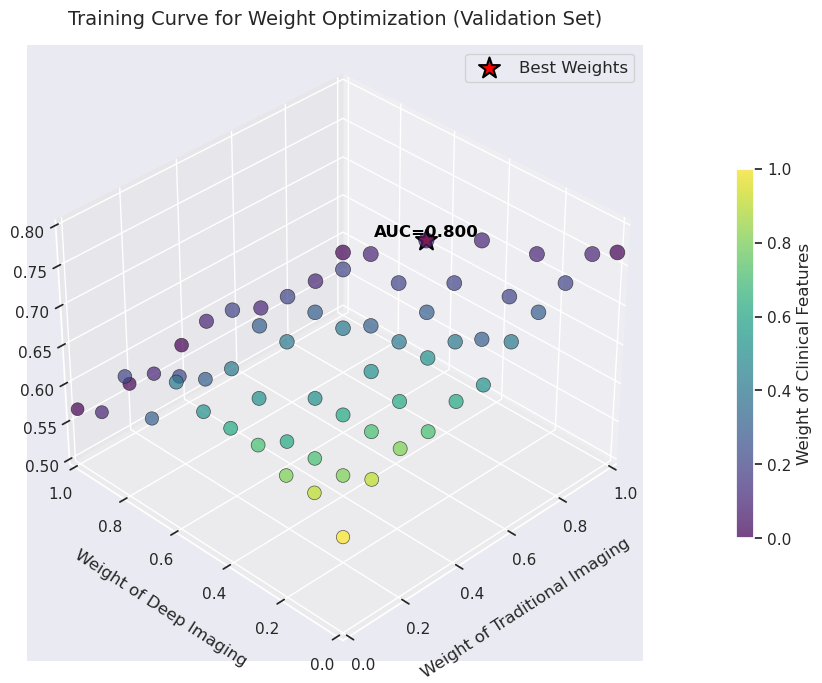

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 假设数据已经存储在变量中
# auc_scores: (N, 4) 形状的数组, 列分别对应 传统影像权重、深度影像权重、临床特征权重、AUC值
# best_weights: (2,) 形状的数组, 对应最佳权重 (传统影像, 深度影像)
# best_auc: 最佳 AUC 值

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 设定视角，使曲线更加直观
ax.view_init(elev=35, azim=225)

# 设定坐标轴范围
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0.5, 0.8)  # 根据 AUC 取值范围调整

# 3D 散点图: 颜色代表临床特征权重，点大小代表 AUC
sc = ax.scatter(
    auc_scores[:, 0], auc_scores[:, 1], auc_scores[:, 3], 
    c=auc_scores[:, 2], s=auc_scores[:, 3] * 150,  # 放大点的大小
    cmap='viridis', alpha=0.7, edgecolors='k', linewidths=0.5
)

# 标出最佳权重组合点
ax.scatter(
    best_weights[0], best_weights[1], best_auc, 
    color='red', s=250, edgecolor='black', linewidth=1.5, label='Best Weights', marker='*'
)

# 添加最佳点的文本标注
ax.text(
    best_weights[0], best_weights[1], best_auc + 0.005, 
    f'AUC={best_auc:.3f}', color='black', fontsize=12, fontweight='bold', ha='center'
)

# 设置坐标轴标签
ax.set_xlabel('Weight of Traditional Imaging', fontsize=12, labelpad=12)
ax.set_ylabel('Weight of Deep Imaging', fontsize=12, labelpad=12)
ax.set_zlabel('AUC', fontsize=12, labelpad=12)

# 添加标题
ax.set_title('Training Curve for Weight Optimization (Validation Set)', fontsize=14, pad=15)

# 添加颜色条，显示临床特征权重
cbar = plt.colorbar(sc, shrink=0.6, aspect=20, pad=0.1)
cbar.set_label('Weight of Clinical Features', fontsize=12)

# 添加图例
ax.legend(loc='upper right', fontsize=12)

# 保存图片
plt.savefig('05.Training_Curve_Weight_Optimization.pdf', format='pdf', bbox_inches='tight', dpi=300)

# 显示图形
plt.show()


### 2.最佳权重在训练集中评估

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix

# 使用最佳权重组合在训练集上进行评估
proba_trad_train = model_trad.predict_proba(X_train_trad)
proba_deep_train = model_deep.predict_proba(X_train_deep)
proba_clinical_train = model_clinical.predict_proba(X_train_clinical)

weighted_proba_train = (best_weights[0] * proba_trad_train[:, 1] +
                        best_weights[1] * proba_deep_train[:, 1] +
                        best_weights[2] * proba_clinical_train[:, 1])

# 计算训练集的各项指标
y_pred_train = (weighted_proba_train > 0.4).astype(int)

F1_train = f1_score(y_train, y_pred_train, average='macro')
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, weighted_proba_train)
AUC_train = auc(fpr_train, tpr_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
TN_train, FP_train, FN_train, TP_train = confusion_matrix(y_train, y_pred_train).ravel()
sensitivity_train = round(TP_train / (TP_train + FN_train), 3)
specificity_train = round(TN_train / (TN_train + FP_train), 3)

# 输出训练集结果
print(f'Training Set Weighted Voting F1 Score: {F1_train:.4f}')
print(f'Training Set Weighted Voting AUC: {AUC_train:.4f}')
print(f'Training Set Weighted Voting Accuracy: {accuracy_train:.4f}')
print(f'Training Set Weighted Voting Sensitivity: {sensitivity_train:.4f}')
print(f'Training Set Weighted Voting Specificity: {specificity_train:.4f}')


Training Set Weighted Voting F1 Score: 0.7538
Training Set Weighted Voting AUC: 0.8053
Training Set Weighted Voting Accuracy: 0.7625
Training Set Weighted Voting Sensitivity: 0.6970
Training Set Weighted Voting Specificity: 0.8090


### 3.最佳权重在测试集中评估

In [81]:
# 使用最佳权重组合在测试集上进行评估
proba_trad_test = model_trad.predict_proba(X_test_trad)
proba_deep_test = model_deep.predict_proba(X_test_deep)
proba_clinical_test = model_clinical.predict_proba(X_test_clinical)

weighted_proba_test = (best_weights[0] * proba_trad_test[:, 1] +
                       best_weights[1] * proba_deep_test[:, 1] +
                       best_weights[2] * proba_clinical_test[:, 1])

# 计算测试集的各项指标
y_pred_test = (weighted_proba_test > 0.4).astype(int)

F1 = f1_score(y_test, y_pred_test, average='macro')
fpr, tpr, thresholds = roc_curve(y_test, weighted_proba_test)
AUC = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred_test)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_test).ravel()
sensitivity = round(TP / (TP + FN), 3)
specificity = round(TN / (TN + FP), 3)

# 输出结果
print(f'Final Weighted Voting F1 Score: {F1:.4f}')
print(f'Final Weighted Voting AUC: {AUC:.4f}')
print(f'Final Weighted Voting Accuracy: {accuracy:.4f}')
print(f'Final Weighted Voting Sensitivity: {sensitivity:.4f}')
print(f'Final Weighted Voting Specificity: {specificity:.4f}')

Final Weighted Voting F1 Score: 0.8810
Final Weighted Voting AUC: 0.9560
Final Weighted Voting Accuracy: 0.9000
Final Weighted Voting Sensitivity: 0.7140
Final Weighted Voting Specificity: 1.0000


### 4.ROC曲线

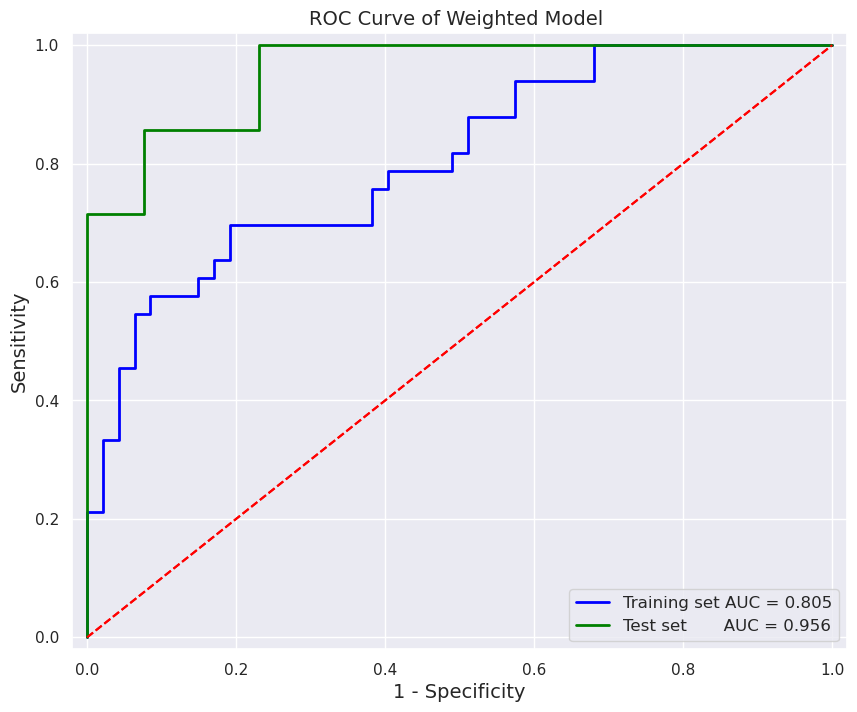

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 定义一个函数来绘制ROC曲线
def plot_roc_curve(k, y_true, y_score, title, classifier_name, color):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(k)
    plt.title(title, fontsize=14)
    plt.plot(fpr, tpr, color=color, lw=2, label='%s AUC = %0.3f' % (classifier_name, roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)

# 训练集的加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])

# 验证集的加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1])
sns.set()
plt.figure(figsize=(10, 8))
# 绘制训练集的ROC曲线
plot_roc_curve(1, y_train, y_pred_train_proba, "ROC Curve of Weighted Model ", "Training set", 'blue') #使用相同的编号 1，将训练集和验证集的ROC曲线绘制在同一张图中
# 绘制验证集的ROC曲线
plot_roc_curve(1, y_test, y_pred_test_proba, "ROC Curve of Weighted Model ", "Test set      ", 'green')

# 显示图形
plt.savefig('ROC Curve of Weighted Model.pdf',format='pdf')
plt.show()


In [36]:
# 获取训练集的预测概率和真实值
y_score_weighted_train = y_pred_train_proba
y_true_weighted_train = y_train

# 获取测试集的预测概率和真实值
y_score_weighted_test = y_pred_test_proba
y_true_weighted_test = y_test

## 5.混淆矩阵

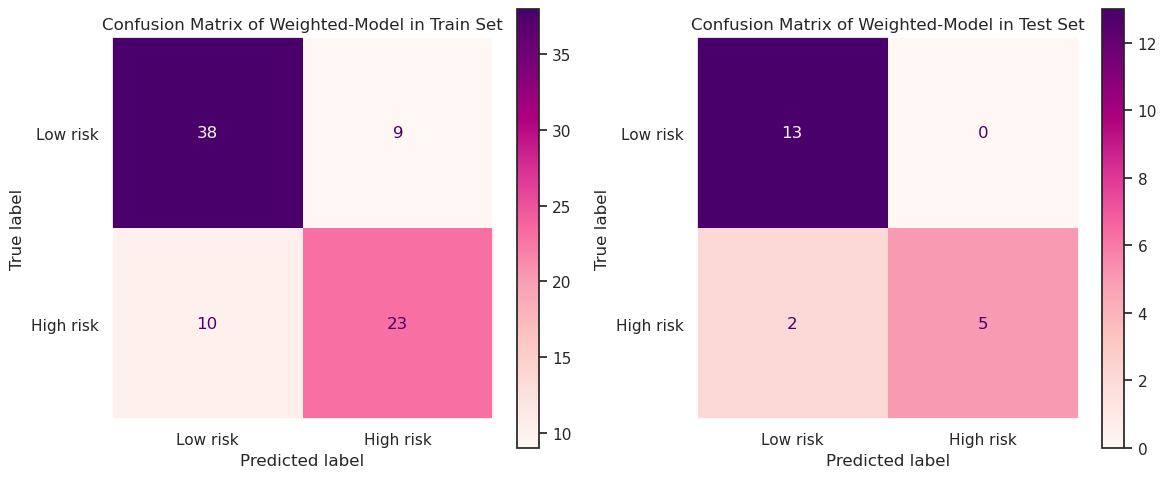

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 计算训练集加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])
y_pred_train = (y_pred_train_proba > 0.4).astype(int)

# 计算测试集加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1]) 
y_pred_test = (y_pred_test_proba > 0.4).astype(int)

# 设置画布和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列，调整大小

# 训练集混淆矩阵
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Low risk', 'High risk'])
sns.set_style("white")
disp_train.plot(cmap='RdPu', ax=axes[0])
axes[0].grid(False)  # Disable gridlines
axes[0].set_title("Confusion Matrix of Weighted-Model in Train Set")

# 测试集混淆矩阵
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Low risk', 'High risk'])
disp_test.plot(cmap='RdPu', ax=axes[1])
axes[1].grid(False)  # Disable gridlines
axes[1].set_title("Confusion Matrix of Weighted-Model in Test Set")

# 调整布局，防止重叠
plt.tight_layout()

# 保存并显示
plt.savefig('05.训练集与测试集混淆矩阵.pdf', format='pdf')
plt.show()

## 6.五折交叉验证

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

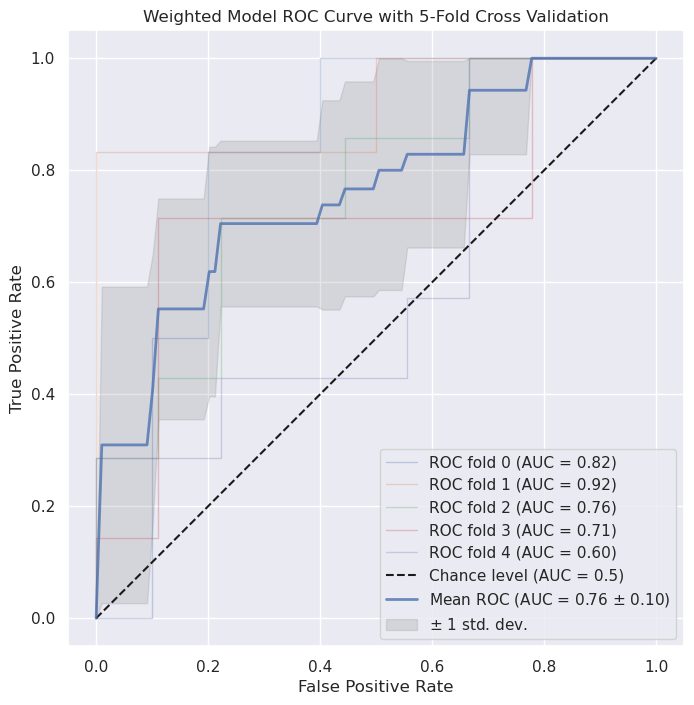

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化
sns.set()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# 替换为训练集的输入数据和标签
X_trad = X_train_trad.values
X_deep = X_train_deep.values
X_clinical = X_train_clinical.values
y = y_train.values

# 初始化图形
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_trad, y)):
    # 获取每折的训练集和测试集
    X_train_trad_fold, X_test_trad_fold = X_trad[train_idx], X_trad[test_idx]
    X_train_deep_fold, X_test_deep_fold = X_deep[train_idx], X_deep[test_idx]
    X_train_clinical_fold, X_test_clinical_fold = X_clinical[train_idx], X_clinical[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    # 训练每个模型
    model_trad.fit(X_train_trad_fold, y_train_fold)
    model_deep.fit(X_train_deep_fold, y_train_fold)
    model_clinical.fit(X_train_clinical_fold, y_train_fold)

    # 获取预测概率
    proba_trad_fold = model_trad.predict_proba(X_test_trad_fold)[:, 1]
    proba_deep_fold = model_deep.predict_proba(X_test_deep_fold)[:, 1]
    proba_clinical_fold = model_clinical.predict_proba(X_test_clinical_fold)[:, 1]

    # 计算加权平均概率
    weighted_proba_fold = (best_weights[0] * proba_trad_fold +
                           best_weights[1] * proba_deep_fold +
                           best_weights[2] * proba_clinical_fold)

    # 绘制ROC曲线
    viz = RocCurveDisplay.from_predictions(
        y_test_fold,
        weighted_proba_fold,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    
    # 插值TPR
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# 计算平均ROC曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# 绘制平均ROC曲线
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# 绘制标准差区域
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

# 设置图形属性
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Weighted Model ROC Curve with 5-Fold Cross Validation",
)
ax.legend(loc="lower right")

# 显示图形
plt.savefig('05.Weighted_Model_ROC_Curve_Cross_Validation.pdf', format='pdf')
plt.show()

# 整合ROC曲线(融合模型对比)

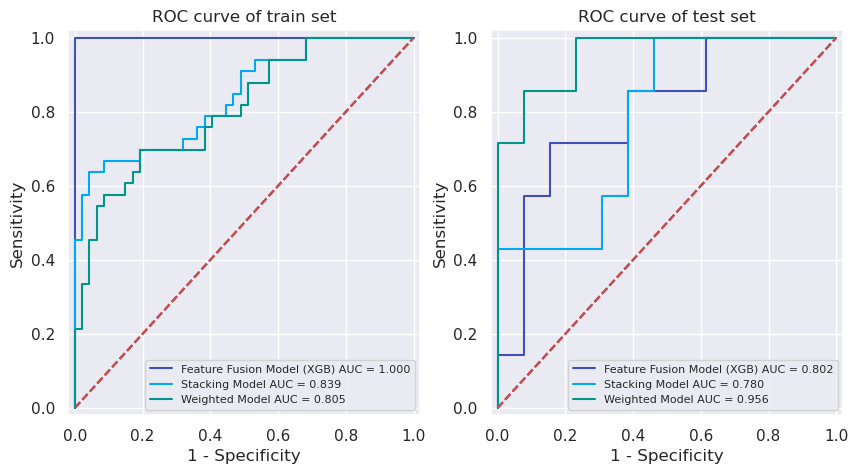

In [70]:
## 获取训练集的预测概率和真实值
#y_score_feature_fusion_train = xgb_model.predict_proba(X_train)[:,1]
#y_true_feature_fusion_train = pd.DataFrame(y_train)
## 获取测试集的预测概率和真实值
#y_score_feature_fusion_test = xgb_model.predict_proba(X_test)[:,1]
#y_true_feature_fusion_test = pd.DataFrame(y_test)
#
#
## 获取训练集的预测概率和真实值
#y_score_stacking_train = y_train_pred_proba
#y_true_stacking_train = y_train
## 获取测试集的预测概率和真实值
#y_score_stacking_test = y_test_pred_proba
#y_true_stacking_test = y_test
#
## 获取训练集的预测概率和真实值
#y_score_weighted_train = y_pred_train_proba
#y_true_weighted_train = y_train
## 获取测试集的预测概率和真实值
#y_score_weighted_test = y_pred_test_proba
#y_true_weighted_test = y_test



plt.style.use('tableau-colorblind10')
def plot_roc(k, y_pred_undersample_score, labels_test, classifiers, color, title):
    fpr, tpr, thresholds = metrics.roc_curve(labels_test.values.ravel(), y_pred_undersample_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='%s AUC = %0.3f' % (classifiers, roc_auc))
    plt.legend(loc='lower right', fontsize=8)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.title(title)

# Set custom figure size for the entire plot
sns.set()
plt.figure(figsize=(10, 5))  # Example of custom size
fontsize = 14 #确保字体大小一致

plt.subplot(1,2,1)
plot_roc(1,y_score_feature_fusion_train,y_true_feature_fusion_train,'Feature Fusion Model (XGB)','#3f51b4','ROC curve of train set')
plot_roc(1,y_score_stacking_train,y_true_stacking_train,'Stacking Model','#03a8f3','ROC curve of train set')
plot_roc(1,y_score_weighted_train,y_true_weighted_train,'Weighted Model','#009587','ROC curve of train set')

plt.subplot(1,2,2)
plot_roc(1,y_score_feature_fusion_test,y_true_feature_fusion_test,'Feature Fusion Model (XGB)','#3f51b4','ROC curve of test set')
plot_roc(1,y_score_stacking_test,y_true_stacking_test,'Stacking Model','#03a8f3','ROC curve of test set')
plot_roc(1,y_score_weighted_test,y_true_weighted_test,'Weighted Model','#009587','ROC curve of test set')

plt.savefig("05.特征级—训练集-测试集ROC曲线.pdf",format="pdf")
plt.show()


# 整合PR曲线(融合模型对比)

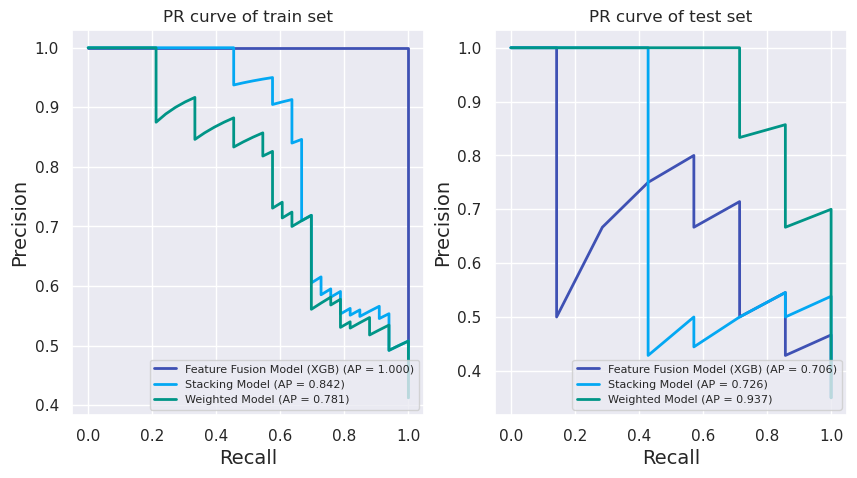

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 定义一个函数来绘制PR曲线
def plot_pr_curve(k, y_true, y_score, method_name, title, color):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    plt.figure(k)
    plt.plot(recall, precision, lw=2, label=f'{method_name} (AP = {ap_score:.3f})', color=color)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title)
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True)

sns.set()
# Set custom figure size for the entire plot
plt.figure(figsize=(10, 5))  # Example of custom size
fontsize = 14 #确保字体大小一致

plt.subplot(1,2,1)
plot_pr_curve(1,y_true_feature_fusion_train,y_score_feature_fusion_train,'Feature Fusion Model (XGB)','PR curve of train set','#3f51b4')
plot_pr_curve(1,y_true_stacking_train,y_score_stacking_train,'Stacking Model','PR curve of train set','#03a8f3')
plot_pr_curve(1,y_true_weighted_train,y_score_weighted_train,'Weighted Model','PR curve of train set','#009587')

plt.subplot(1,2,2)
plot_pr_curve(1,y_true_feature_fusion_test,y_score_feature_fusion_test,'Feature Fusion Model (XGB)','PR curve of test set','#3f51b4')
plot_pr_curve(1,y_true_stacking_test,y_score_stacking_test,'Stacking Model','PR curve of test set','#03a8f3')
plot_pr_curve(1,y_true_weighted_test,y_score_weighted_test,'Weighted Model','PR curve of test set','#009587')

plt.savefig("05.特征级—训练集-测试集PR曲线.pdf",format="pdf")
plt.show()

# 显示图形
#plt.savefig('PR Curve of Weighted Model.pdf',format='pdf')



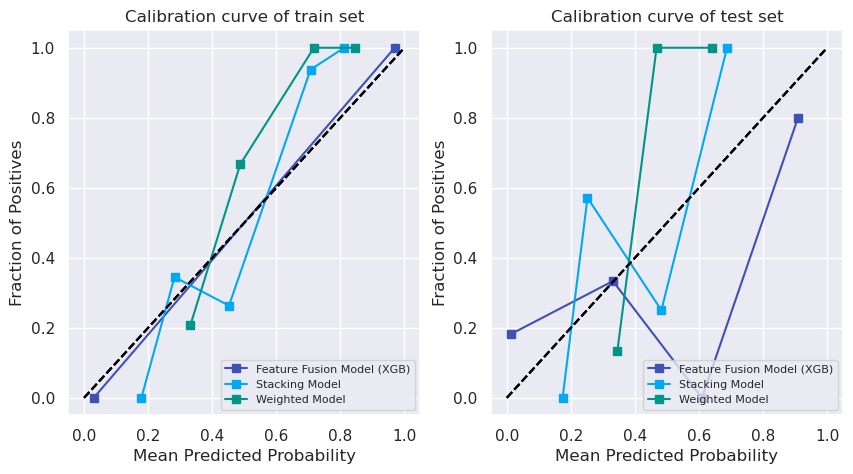

In [95]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# 定义一个函数来绘制校准曲线
def plot_calibration_curve(k, y_true, y_pred,  method_name,title, color):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5)
    plt.figure(k)
    plt.plot(prob_pred, prob_true, color=color, label=f'{method_name}', marker='s')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # 完美校准线
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True)
    
sns.set()
# Set custom figure size for the entire plot
plt.figure(figsize=(10, 5))  # Example of custom size
fontsize = 14 #确保字体大小一致

plt.subplot(1,2,1)
# 绘制训练集的校准曲线
plot_calibration_curve(1,y_true_feature_fusion_train,y_score_feature_fusion_train,'Feature Fusion Model (XGB)','Calibration Curve of train set','#3f51b4')
plot_calibration_curve(1,y_true_stacking_train,y_score_stacking_train,'Stacking Model','Calibration curve of train set','#03a8f3')
plot_calibration_curve(1,y_true_weighted_train,y_score_weighted_train,'Weighted Model','Calibration curve of train set','#009587')


plt.subplot(1,2,2)
plot_calibration_curve(1,y_true_feature_fusion_test,y_score_feature_fusion_test,'Feature Fusion Model (XGB)','Calibration curve of test set','#3f51b4')
plot_calibration_curve(1,y_true_stacking_test,y_score_stacking_test,'Stacking Model','Calibration curve of test set','#03a8f3')
plot_calibration_curve(1,y_true_weighted_test,y_score_weighted_test,'Weighted Model','Calibration curve of test set','#009587')


#plt.savefig("特征级—训练集-测试集ROC曲线.pdf",format="pdf")
plt.show()




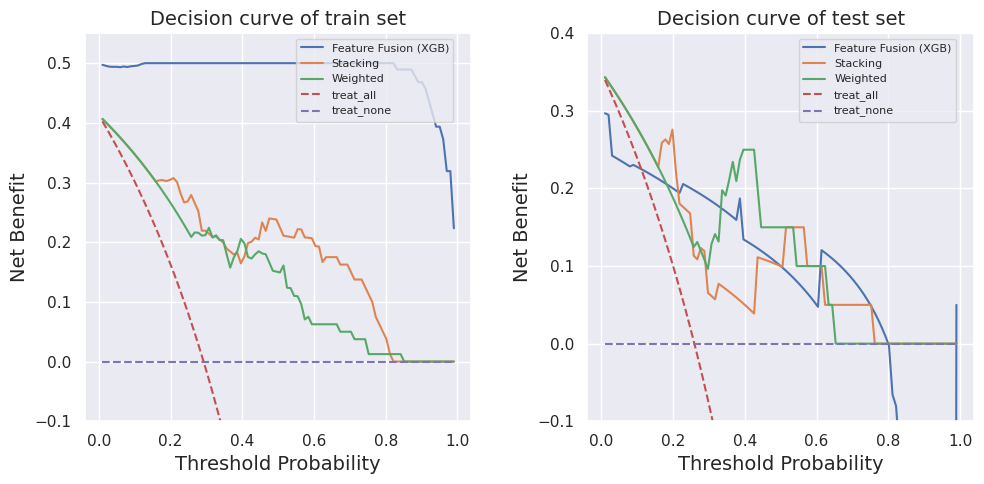

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def dca(models, thresholds=np.linspace(0.01, 0.99, 100)):
    """
    计算决策曲线分析（DCA）
    
    参数:
        models (dict): 包含多个模型的真实标签和预测概率，例如：
            models = {
                "Feature Fusion": (y_true_feature_fusion, y_score_feature_fusion),
                "Stacking": (y_true_stacking, y_score_stacking),
                "Weighted": (y_true_weighted, y_score_weighted)
            }
        thresholds (numpy array): 计算净获益的阈值范围
    
    返回:
        pd.DataFrame: 包含阈值、不同模型的净收益、Treat All 和 Treat None 的数据框
    """
    results = {"threshold": thresholds}

    for model_name, (y_true, y_score) in models.items():
        y_true = np.array(y_true).flatten()
        y_score = np.array(y_score).flatten()
        net_benefits = []

        for t in thresholds:
            predicted_positive = y_score >= t
            tp = np.sum(predicted_positive & (y_true == 1))
            fp = np.sum(predicted_positive & (y_true == 0))
            total = len(y_true)

            if total == 0:
                nb = np.nan
            else:
                nb = (tp / total) - (fp / total) * (t / (1 - t)) if (1 - t) > 1e-6 else np.nan

            net_benefits.append(nb)

        results[model_name] = net_benefits

    # Treat All 策略（所有人都接受治疗）
    treat_all = [np.mean(y_true) - (t / (1 - t)) if t < 0.99 else np.nan for t in thresholds]
    results["treat_all"] = treat_all

    # Treat None 策略（无人接受治疗，净获益恒为0）
    results["treat_none"] = np.zeros_like(thresholds)

    df_results = pd.DataFrame(results)

    return df_results

def plot_decision_curve(ax, plot_df, dataset_name, y_limits=[-0.1, 0.3], fontsize=14, legend_position=(0.5, 1.2)):
    """
    绘制单独的决策曲线（DCA），支持 **手动调整 legend 位置**
    
    参数:
        ax (matplotlib.axes): 指定绘图的 `axes`，用于 `subplot()`
        plot_df (pd.DataFrame): DCA 计算结果
        dataset_name (str): 数据集名称 ("Train" 或 "Test")
        y_limits (list): y 轴的范围
        fontsize (int): 字体大小
        legend_position (tuple): legend 的 (x, y) 坐标（用于 `bbox_to_anchor` 手动调整）
    """
    lines = []
    labels = []
    
    for column in plot_df.columns:
        if column == "threshold":
            continue
        linestyle = '--' if column in ["treat_all", "treat_none"] else '-'
        line, = ax.plot(plot_df["threshold"], plot_df[column], label=column, linestyle=linestyle)
        lines.append(line)
        labels.append(column)

    ax.set_xlabel("Threshold Probability", fontsize=fontsize)
    ax.set_ylabel("Net Benefit", fontsize=fontsize)
    ax.set_title(f"Decision curve of {dataset_name} set", fontsize=fontsize)
    ax.set_ylim(y_limits)
    ax.grid(True)
    
    # 让 legend 位置可手动调整
    ax.legend(lines, labels, loc="upper center", bbox_to_anchor=legend_position, fontsize=8)

# 训练集模型
models_train = {
    "Feature Fusion (XGB)": (y_true_feature_fusion_train, y_score_feature_fusion_train),
    "Stacking": (y_true_stacking_train, y_score_stacking_train),
    "Weighted": (y_true_weighted_train, y_score_weighted_train)
}

# 测试集模型
models_test = {
    "Feature Fusion (XGB)": (y_true_feature_fusion_test, y_score_feature_fusion_test),
    "Stacking": (y_true_stacking_test, y_score_stacking_test),
    "Weighted": (y_true_weighted_test, y_score_weighted_test)
}

# 计算训练集 DCA
dca_train = dca(models_train)

# 计算测试集 DCA
dca_test = dca(models_test)

# 创建 1 行 2 列的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

# **手动调整 legend 位置**
train_legend_position = (0.75, 1.0)  # **训练集 legend 上移**
test_legend_position = (0.75, 1.0)  # **测试集 legend 也上移**

# 绘制训练集 DCA
plot_decision_curve(axes[0], dca_train, dataset_name="train", y_limits=[-0.1, 0.55], legend_position=train_legend_position)

# 绘制测试集 DCA
plot_decision_curve(axes[1], dca_test, dataset_name="test", y_limits=[-0.1, 0.4], legend_position=test_legend_position)

# 调整子图布局，防止重叠
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# 保存 PDF（可选）
# plt.savefig("decision_curve_analysis.pdf", format="pdf")

plt.show()


# 测试集Calibration和DC曲线(融合模型对比)

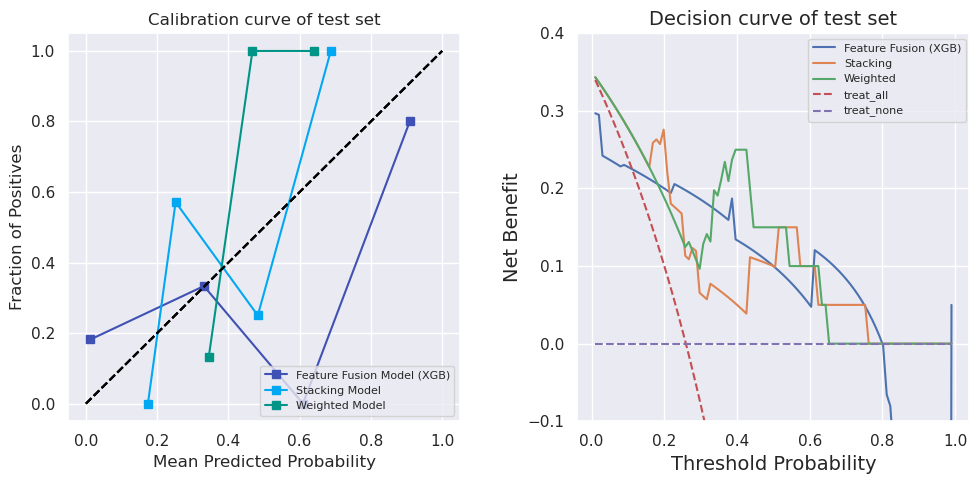

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 主题
sns.set()

# 计算测试集 DCA（修正顺序）
models_test = {
    "Feature Fusion (XGB)": (y_true_feature_fusion_test, y_score_feature_fusion_test),
    "Stacking": (y_true_stacking_test, y_score_stacking_test),
    "Weighted": (y_true_weighted_test, y_score_weighted_test)
}

dca_test = dca(models_test)  # ✅ 先定义 models_test，再计算 dca_test

# 创建 1x2 的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
fontsize = 14  # 确保字体大小一致

# **左侧图：校准曲线**
plt.sca(axes[0])  # 设置当前绘图区域为左侧子图
plot_calibration_curve(1, y_true_feature_fusion_test, y_score_feature_fusion_test, 'Feature Fusion Model (XGB)', 'Calibration curve of test set', '#3f51b4')
plot_calibration_curve(1, y_true_stacking_test, y_score_stacking_test, 'Stacking Model', 'Calibration curve of test set', '#03a8f3')
plot_calibration_curve(1, y_true_weighted_test, y_score_weighted_test, 'Weighted Model', 'Calibration curve of test set', '#009587')

# **右侧图：决策曲线**
test_legend_position = (0.79, 1.0)  # 上移 legend
plot_decision_curve(axes[1], dca_test, dataset_name="test", y_limits=[-0.1, 0.4], legend_position=test_legend_position)

# **优化布局**
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# **可选：保存 PDF**
plt.savefig("05.测试集Calibration-DC曲线.pdf", format="pdf")

plt.show()


# 训练集Calibration和DC曲线(融合模型对比)

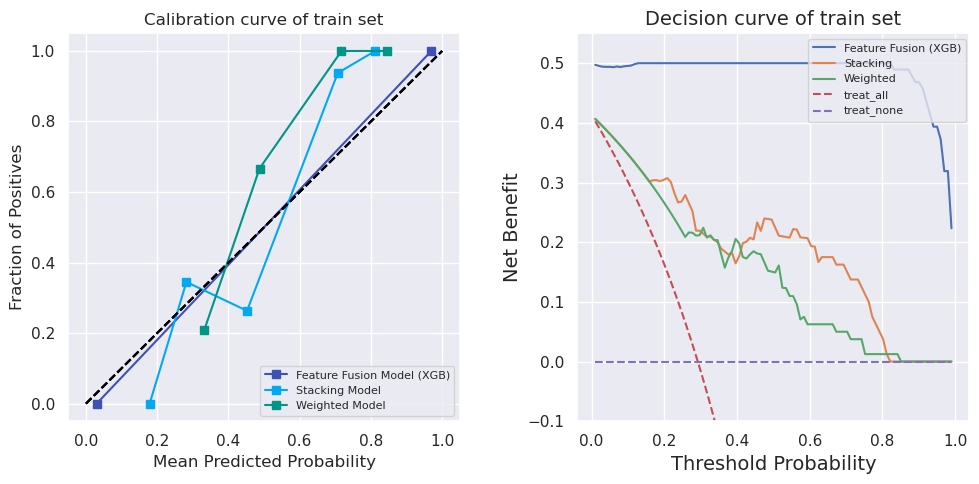

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 主题
sns.set()

# 训练集模型
models_train = {
    "Feature Fusion (XGB)": (y_true_feature_fusion_train, y_score_feature_fusion_train),
    "Stacking": (y_true_stacking_train, y_score_stacking_train),
    "Weighted": (y_true_weighted_train, y_score_weighted_train)
}

# 计算训练集 DCA
dca_train = dca(models_train)  

# 创建 1x2 的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
fontsize = 14  # 确保字体大小一致

# **左侧图：校准曲线**
plt.sca(axes[0])  # 设置当前绘图区域为左侧子图
plot_calibration_curve(1,y_true_feature_fusion_train,y_score_feature_fusion_train,'Feature Fusion Model (XGB)','Calibration Curve of train set','#3f51b4')
plot_calibration_curve(1,y_true_stacking_train,y_score_stacking_train,'Stacking Model','Calibration curve of train set','#03a8f3')
plot_calibration_curve(1,y_true_weighted_train,y_score_weighted_train,'Weighted Model','Calibration curve of train set','#009587')

# **右侧图：决策曲线**
test_legend_position = (0.79, 1.0)  # 上移 legend
plot_decision_curve(axes[1], dca_train, dataset_name="train", y_limits=[-0.1, 0.55], legend_position=test_legend_position)

# **优化布局**
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# **可选：保存 PDF**
plt.savefig("05.训练集Calibration-DC曲线.pdf.pdf", format="pdf")

plt.show()

# 测试集ROC和PR曲线(融合模型对比)

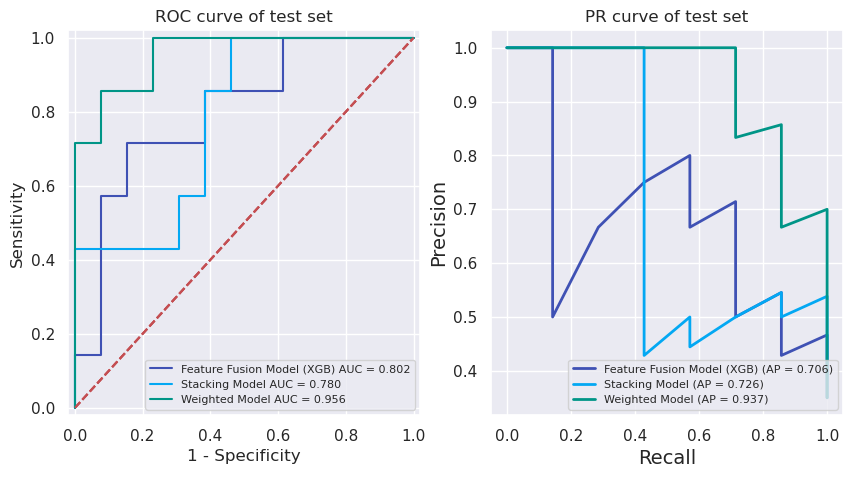

In [72]:
plt.style.use('tableau-colorblind10')
def plot_roc(k, y_pred_undersample_score, labels_test, classifiers, color, title):
    fpr, tpr, thresholds = metrics.roc_curve(labels_test.values.ravel(), y_pred_undersample_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='%s AUC = %0.3f' % (classifiers, roc_auc))
    plt.legend(loc='lower right',fontsize=8)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.title(title)
    
# 定义一个函数来绘制PR曲线
def plot_pr_curve(k, y_true, y_score, method_name, title, color):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    plt.figure(k)
    plt.plot(recall, precision, lw=2, label=f'{method_name} (AP = {ap_score:.3f})', color=color)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title)
    plt.legend(loc='lower right' ,fontsize=8)
    plt.grid(True)

# Set custom figure size for the entire plot
plt.figure(figsize=(10, 5))  # Example of custom size
fontsize = 14 #确保字体大小一致

plt.subplot(1,2,1)
plot_roc(1,y_score_feature_fusion_test,y_true_feature_fusion_test,'Feature Fusion Model (XGB)','#3f51b4','ROC curve of test set')
plot_roc(1,y_score_stacking_test,y_true_stacking_test,'Stacking Model','#03a8f3','ROC curve of test set')
plot_roc(1,y_score_weighted_test,y_true_weighted_test,'Weighted Model','#009587','ROC curve of test set')

plt.subplot(1,2,2)
plot_pr_curve(1,y_true_feature_fusion_test,y_score_feature_fusion_test,'Feature Fusion Model (XGB)','PR curve of test set','#3f51b4')
plot_pr_curve(1,y_true_stacking_test,y_score_stacking_test,'Stacking Model','PR curve of test set','#03a8f3')
plot_pr_curve(1,y_true_weighted_test,y_score_weighted_test,'Weighted Model','PR curve of test set','#009587')

plt.savefig("05.测试集ROC-PR曲线.pdf",format="pdf")
plt.show()


# 训练集ROC和PR曲线(融合模型对比)

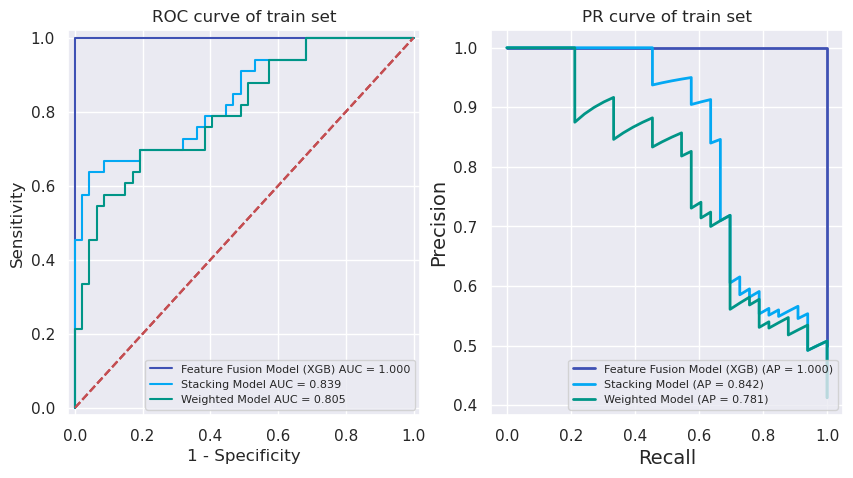

In [73]:
plt.style.use('tableau-colorblind10')
def plot_roc(k, y_pred_undersample_score, labels_test, classifiers, color, title):
    fpr, tpr, thresholds = metrics.roc_curve(labels_test.values.ravel(), y_pred_undersample_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='%s AUC = %0.3f' % (classifiers, roc_auc))
    plt.legend(loc='lower right',fontsize=8)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.title(title)
    
# 定义一个函数来绘制PR曲线
def plot_pr_curve(k, y_true, y_score, method_name, title, color):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    plt.figure(k)
    plt.plot(recall, precision, lw=2, label=f'{method_name} (AP = {ap_score:.3f})', color=color)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title)
    plt.legend(loc='lower right',fontsize=8)
    plt.grid(True)

# Set custom figure size for the entire plot
plt.figure(figsize=(10, 5))  # Example of custom size
fontsize = 14 #确保字体大小一致

plt.subplot(1,2,1)
plot_roc(1,y_score_feature_fusion_train,y_true_feature_fusion_train,'Feature Fusion Model (XGB)','#3f51b4','ROC curve of train set')
plot_roc(1,y_score_stacking_train,y_true_stacking_train,'Stacking Model','#03a8f3','ROC curve of train set')
plot_roc(1,y_score_weighted_train,y_true_weighted_train,'Weighted Model','#009587','ROC curve of train set')

plt.subplot(1,2,2)
plot_pr_curve(1,y_true_feature_fusion_train,y_score_feature_fusion_train,'Feature Fusion Model (XGB)','PR curve of train set','#3f51b4')
plot_pr_curve(1,y_true_stacking_train,y_score_stacking_train,'Stacking Model','PR curve of train set','#03a8f3')
plot_pr_curve(1,y_true_weighted_train,y_score_weighted_train,'Weighted Model','PR curve of train set','#009587')

plt.savefig("05.训练集ROC-PR曲线.pdf",format="pdf")
plt.show()


# 雷达图(融合模型对比)

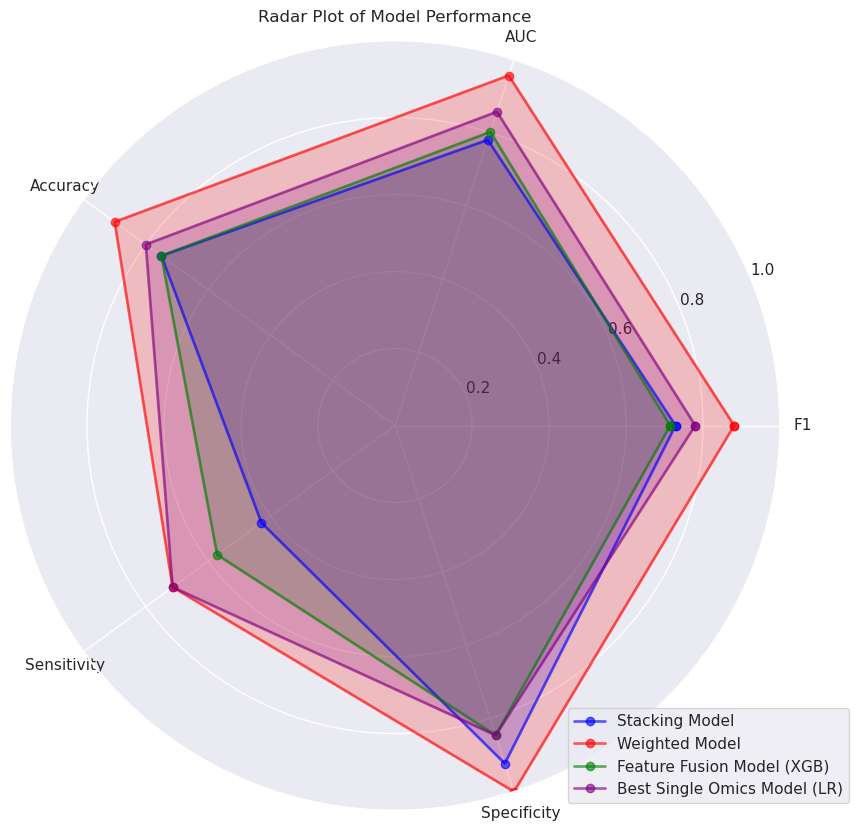

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 定义指标标签
S_labels = ['F1', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity']

# 各模型的性能指标
Stacking_Model = [0.7288, 0.7802, 0.7500, 0.4290, 0.9230]
Weighted_Model = [0.8810, 0.9560, 0.9000, 0.7140, 1.0000]
Feature_fusion_model = [0.715, 0.802, 0.75, 0.571, 0.846]
LR_Model = [0.780, 0.857, 0.80, 0.714, 0.846]  # LR（最佳单组学模型）

# 让数据闭合，以便形成完整的雷达图
Stacking_Model = np.concatenate((Stacking_Model, [Stacking_Model[0]]))
Weighted_Model = np.concatenate((Weighted_Model, [Weighted_Model[0]]))
Feature_fusion_model = np.concatenate((Feature_fusion_model, [Feature_fusion_model[0]]))
LR_Model = np.concatenate((LR_Model, [LR_Model[0]]))

# 计算每个指标的角度
angles = np.linspace(0, 2 * np.pi, len(S_labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 使图形闭合

# 创建雷达图
fig = plt.figure(figsize=(10, 10))  # 设置画布大小
ax = fig.add_subplot(111, polar=True)

# 绘制 Stacking Model
ax.plot(angles, Stacking_Model, 'o-', linewidth=2, alpha=0.6, label='Stacking Model', color='blue')
ax.fill(angles, Stacking_Model, alpha=0.2, color='blue')

# 绘制 Weighted Model
ax.plot(angles, Weighted_Model, 'o-', linewidth=2, alpha=0.6, label='Weighted Model', color='red')
ax.fill(angles, Weighted_Model, alpha=0.2, color='red')

# 绘制 Feature Fusion Model
ax.plot(angles, Feature_fusion_model, 'o-', linewidth=2, alpha=0.6, label='Feature Fusion Model (XGB)', color='green')
ax.fill(angles, Feature_fusion_model, alpha=0.2, color='green')

# 绘制 LR Model（最佳单组学模型）
ax.plot(angles, LR_Model, 'o-', linewidth=2, alpha=0.6, label='Best Single Omics Model (LR)', color='purple')
ax.fill(angles, LR_Model, alpha=0.2, color='purple')

# 设置雷达图的指标标签
ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels=S_labels)

# 设置雷达图刻度范围
ax.set_ylim(0, 1)
ax.grid(True)

# 添加标题
plt.title('Radar Plot of Model Performance')

# 调整图例位置，避免遮挡
#plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))  
plt.legend(loc="lower right", bbox_to_anchor=(1.1, 0))  # Adjust anchor position  

# 保存并显示图像
plt.savefig('05.Radar Plot of Model Performance.pdf', format="pdf")
plt.show()